# Gradient Boosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score
%matplotlib inline

In [3]:
train = pd.read_csv("Data/trainmar.csv")
test = pd.read_csv("Data/testmar.csv")

print("train: {}".format(train.shape))
print("test: {}".format(test.shape))

train.head(10)

train: (4209, 378)
test: (4209, 377)


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
5,18,92.93,t,b,e,c,d,g,h,s,...,0,0,1,0,0,0,0,0,0,0
6,24,128.76,al,r,e,f,d,f,h,s,...,0,0,0,0,0,0,0,0,0,0
7,25,91.91,o,l,as,f,d,f,j,a,...,0,0,0,0,0,0,0,0,0,0
8,27,108.67,w,s,as,e,d,f,i,h,...,1,0,0,0,0,0,0,0,0,0
9,30,126.99,j,b,aq,c,d,f,a,e,...,0,0,1,0,0,0,0,0,0,0


In [4]:
test.head(10)

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0
5,8,y,aa,ai,e,d,x,g,s,0,...,1,0,0,0,0,0,0,0,0,0
6,10,x,b,ae,d,d,x,d,y,0,...,0,0,0,0,0,1,0,0,0,0
7,11,f,s,ae,c,d,h,d,a,0,...,0,0,1,0,0,0,0,0,0,0
8,12,ap,l,s,c,d,h,j,n,0,...,0,0,0,0,0,0,0,0,0,0
9,14,o,v,as,f,d,g,f,v,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train["y"].dtype

dtype('float64')

In [6]:
train["y"].describe()

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64

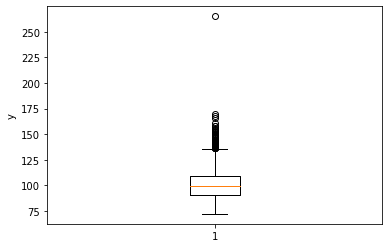

In [7]:
plt.figure()
plt.boxplot(train["y"])
plt.ylabel("y")
plt.show()

The data seems to be skeewed. We have a lot of outliers.  
Let's look at the distribution without the outliers.

In [8]:
q75, q25 = np.percentile(train["y"], [75, 25])
iqr = q75 - q25

minimum = q25 - (iqr * 1.5)
maximum = q75 + (iqr * 1.5)

print("Minimum = %.2f" % minimum)
print("Maximim = %.2f" % maximum)

Minimum = 63.53
Maximim = 136.30


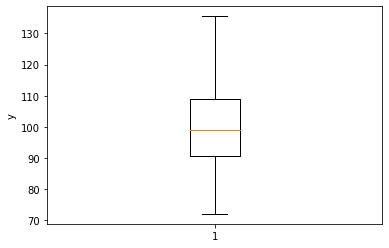

In [9]:
plt.figure()
plt.boxplot(train["y"][(train["y"] >= minimum) & (train["y"] <= maximum)])
plt.ylabel("y")
plt.show()

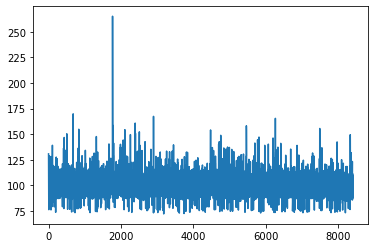

In [10]:
plt.plot(train["ID"], train["y"])

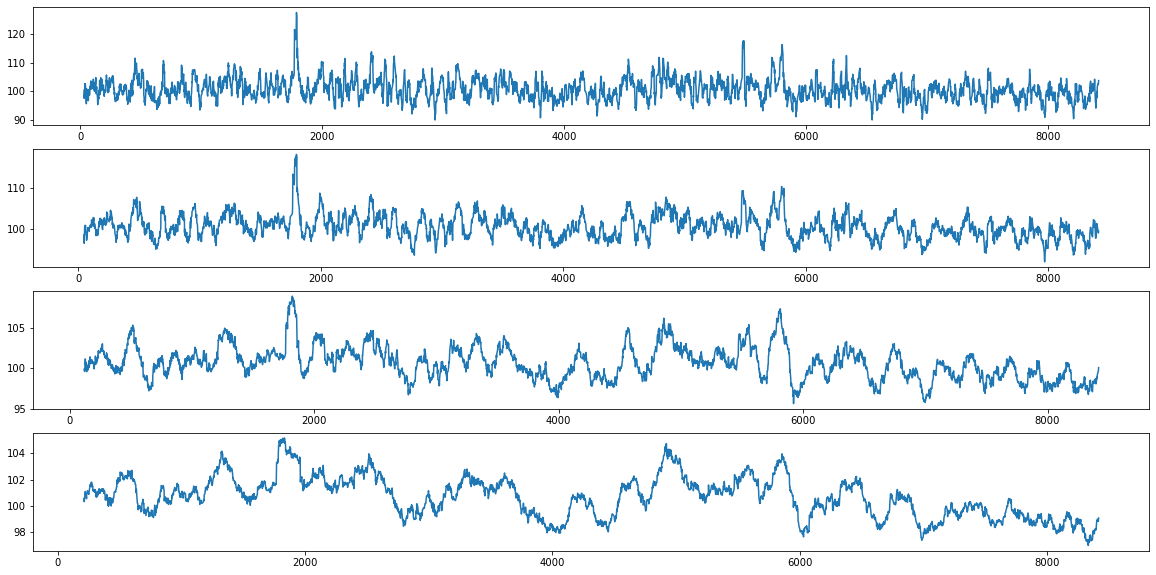

In [11]:
periods = [10,20,50,100]

fig = plt.figure(figsize=(20,10))

for n in periods:
    col = "MA" + str(n)
    train[col] = train["y"].rolling(window=n).mean()

ax1 = fig.add_subplot(411)
ax1.plot(train["ID"], train["MA10"])

ax2 = fig.add_subplot(412)
ax2.plot(train["ID"], train["MA20"])

ax3 = fig.add_subplot(413)
ax3.plot(train["ID"], train["MA50"])

ax4 = fig.add_subplot(414)
ax4.plot(train["ID"], train["MA100"])

In [12]:
for col in ["MA10","MA20","MA50","MA100"]:
    train[col].fillna(train["y"].mean(), inplace=True)

In [13]:
cols = [c for c in train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

In [14]:
counts = [[], [], []]
for c in cols:
    typ = train[c].dtype
    uniq = len(np.unique(train[c]))
    if uniq == 1: counts[0].append(c)
    elif uniq == 2 and typ == np.int64: counts[1].append(c)
    else: counts[2].append(c)

print('Constant features: {}\nBinary features: {}\nCategorical features: {}\n'.format(*[len(c) for c in counts]))

print('Constant features:', counts[0])
print('Categorical features:', counts[2])

Constant features: 12
Binary features: 356
Categorical features: 8

Constant features: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
Categorical features: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


In [15]:
cat_feat = counts[2]
train[cat_feat].head()

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n


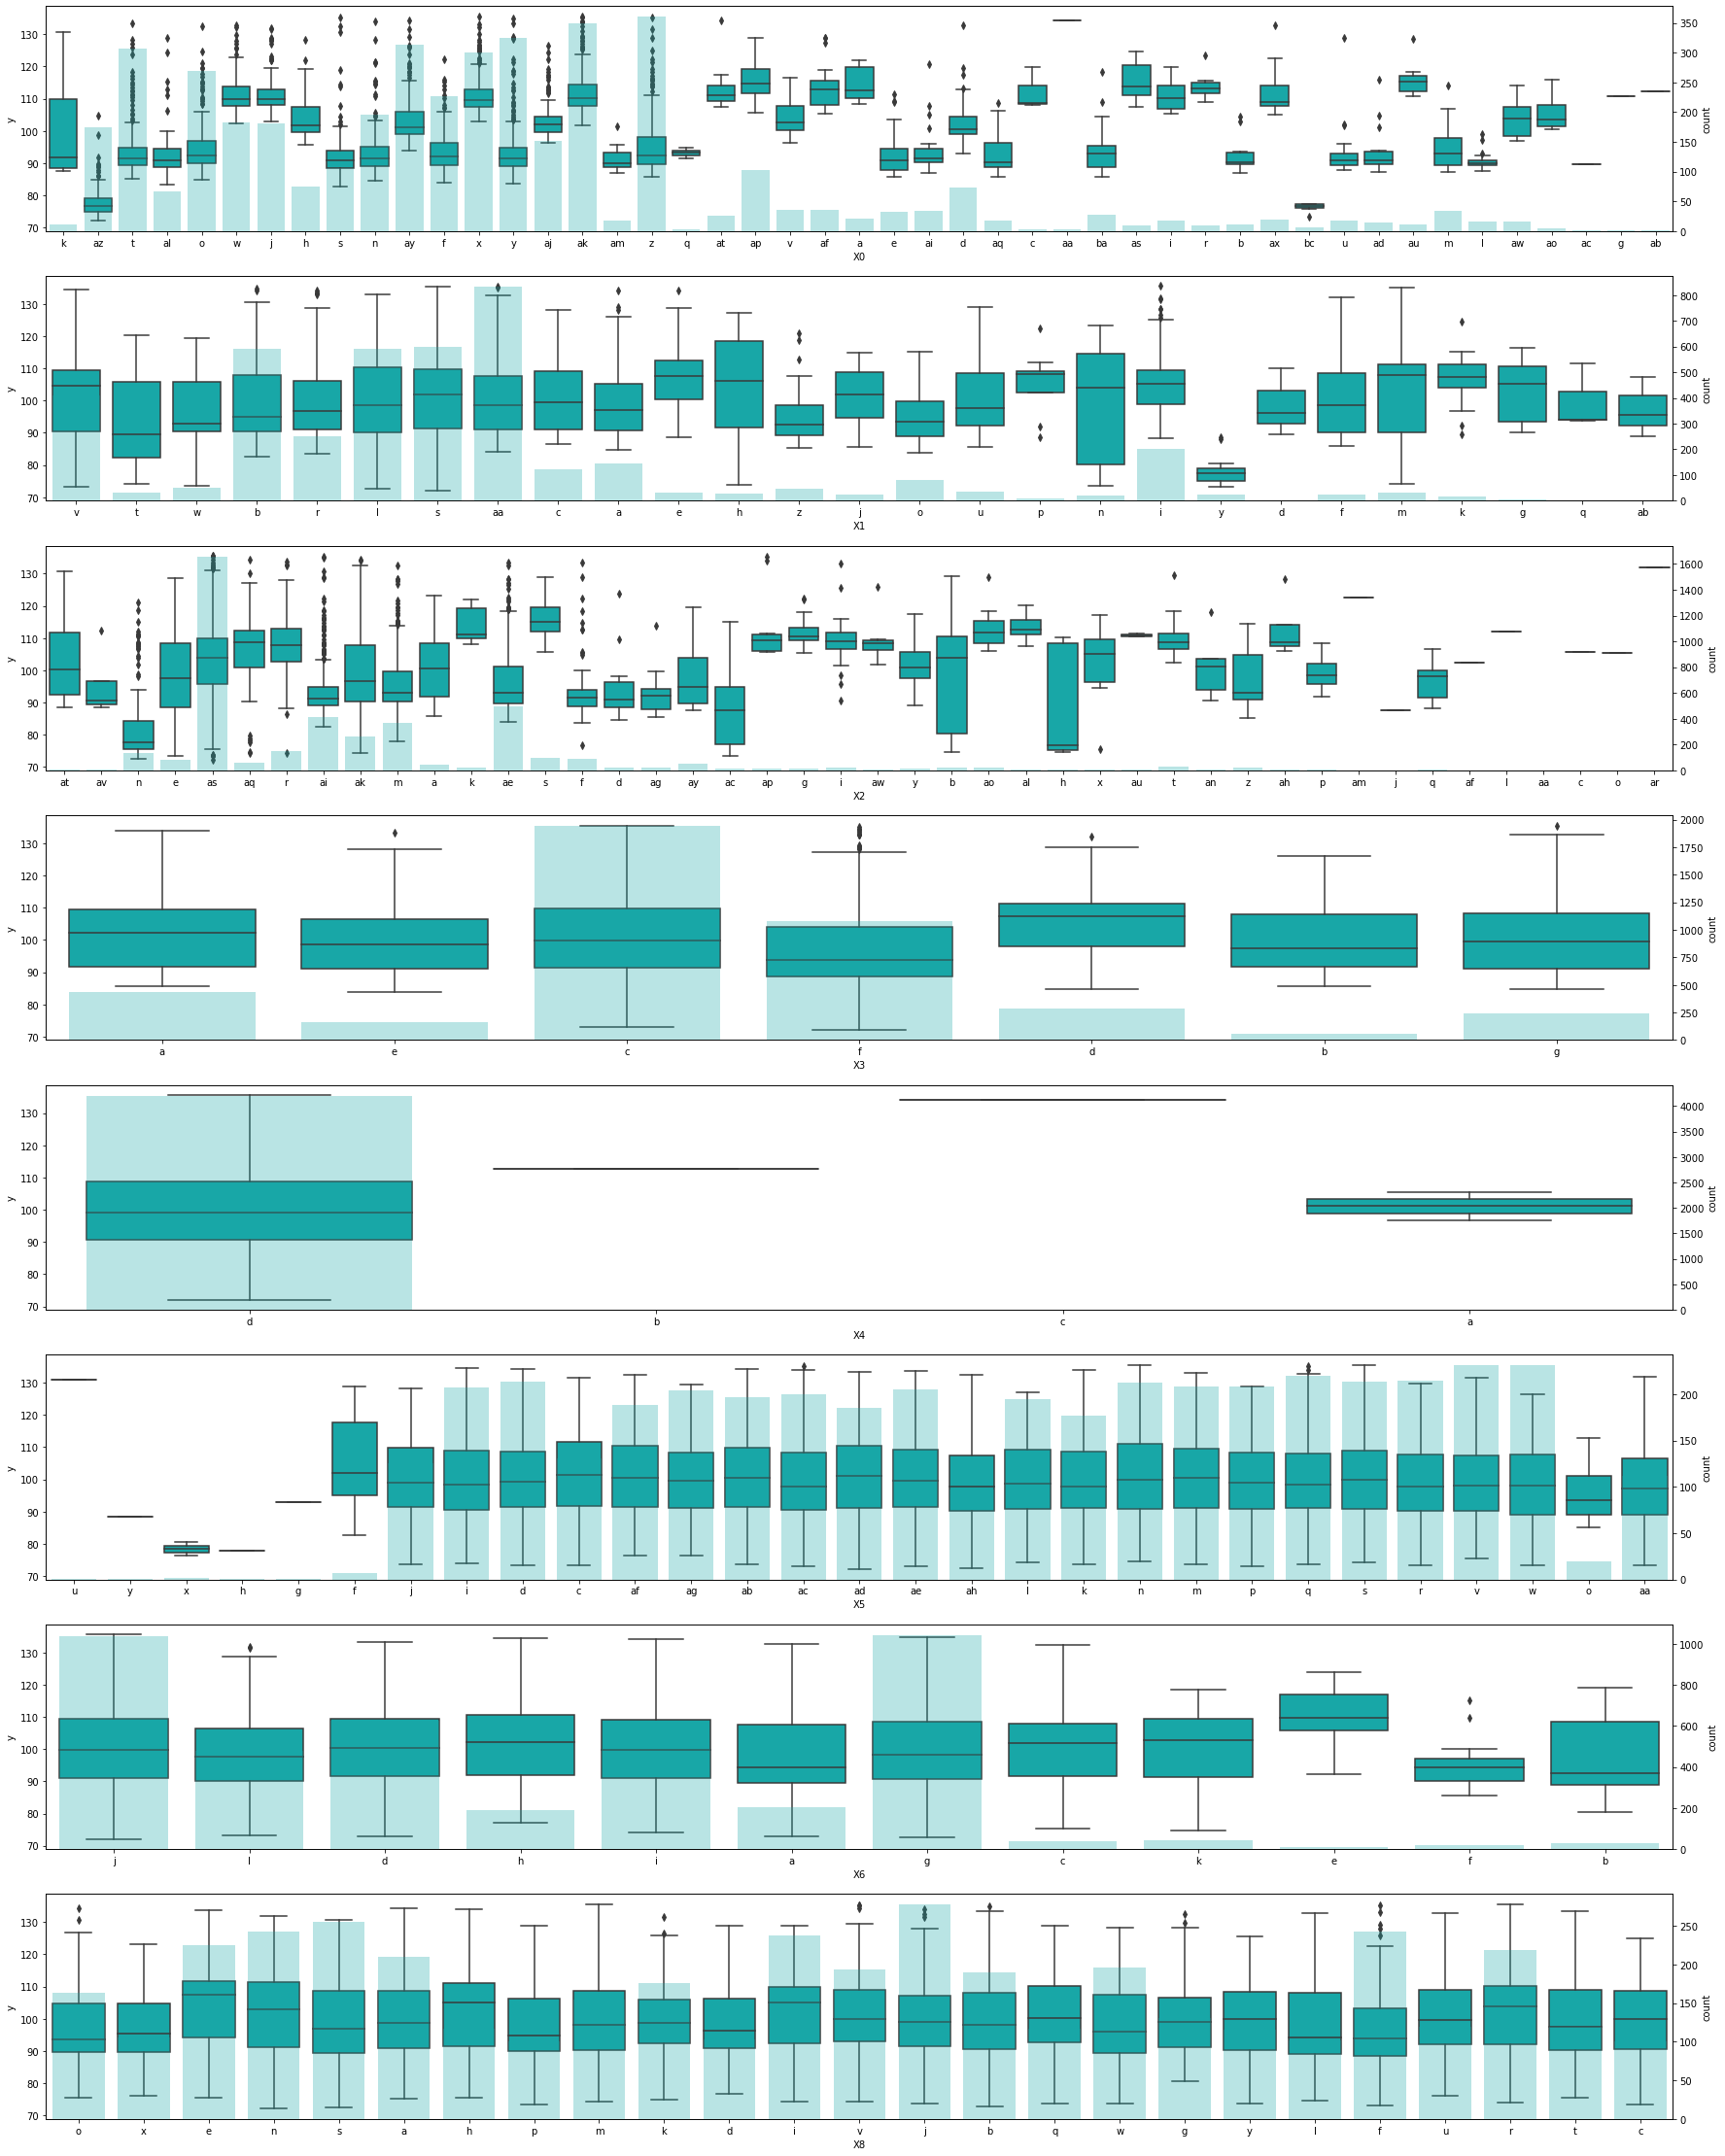

In [16]:
fig, ax = plt.subplots(8, 1, figsize=(30,40))
for c in cat_feat:
    axis = ax[cat_feat.index(c)]
    ax2 = axis.twinx()
    sns.boxplot(x=train[c], y=train["y"][(train["y"] >= minimum) & (train["y"] <= maximum)], color="c", ax=axis)
    sns.countplot(x=train[c], alpha=0.3, color="c", ax=ax2)

In [17]:
binary_features = counts[1]
len(binary_features)

356

In [18]:
train["total"] = train[binary_features].sum(axis=1)

In [19]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X380,X382,X383,X384,X385,MA10,MA20,MA50,MA100,total
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,0,0,0,100.669318,100.669318,100.669318,100.669318,52
1,6,88.53,k,t,av,e,d,y,l,o,...,0,0,0,0,0,100.669318,100.669318,100.669318,100.669318,52
2,7,76.26,az,w,n,c,d,x,j,x,...,0,1,0,0,0,100.669318,100.669318,100.669318,100.669318,73
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,100.669318,100.669318,100.669318,100.669318,62
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,100.669318,100.669318,100.669318,100.669318,58


count    4209.000000
mean       58.023283
std         7.784614
min        31.000000
25%        53.000000
50%        58.000000
75%        63.000000
max        94.000000
Name: total, dtype: float64


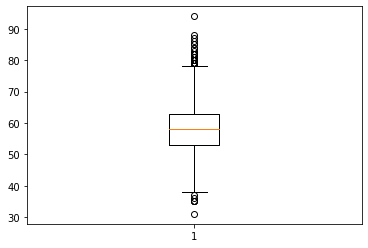

In [20]:
print(train["total"].describe())
plt.boxplot(train["total"])
plt.show()

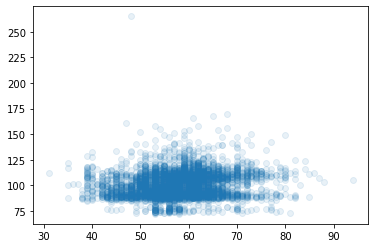

In [21]:
plt.scatter(train["total"], train["y"], alpha=0.1)

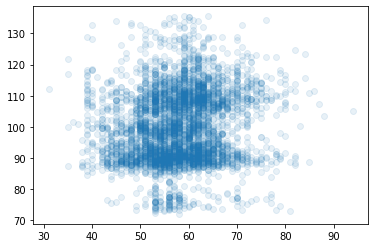

In [22]:
plt.scatter(train["total"][(train["y"] >= minimum) & (train["y"] <= maximum)], 
            train["y"][(train["y"] >= minimum) & (train["y"] <= maximum)], 
            alpha=0.1)

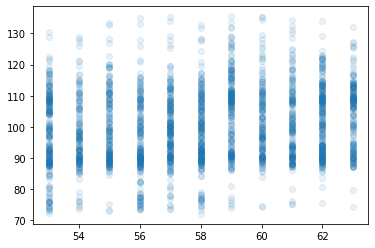

In [23]:
# Limit total values to IQR
plt.scatter(train["total"][(train["y"] >= minimum) & (train["y"] <= maximum) & (train["total"] >= 53) & (train["total"] <= 63)], 
            train["y"][(train["y"] >= minimum) & (train["y"] <= maximum) & (train["total"] >= 53) & (train["total"] <= 63)], 
            alpha=0.1)

In [24]:
test["total"] = test[binary_features].sum(axis=1)
train.drop(["MA10", "MA20", "MA50", "MA100"],axis=1, inplace=True)

In [25]:
def dummify(df, columns, drop=True):
    for column in columns:
        df_dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df,df_dummies], axis=1)
        if drop == True:
            df.drop([column], inplace=True, axis=1)
    return df


def add_missing_dummy_columns(df, columns):
    missing_cols = set(columns) - set(df.columns)
    for c in missing_cols:
        df[c] = 0

Create dummy variables for categorical features

In [26]:
old_col_train = list(train.drop(cat_feat, axis=1).columns)
old_col_test = list(test.drop(cat_feat, axis=1).columns)

train = dummify(train, cat_feat, True)
test = dummify(test, cat_feat, True)

new_col_train = [c for c in list(train.columns) if c not in old_col_train]
new_col_test = [c for c in list(test.columns) if c not in old_col_test]

add_missing_dummy_columns(test, new_col_train)
add_missing_dummy_columns(train, new_col_test)

In [27]:
print("Train: {}".format(train.shape))
print("Test: {}".format(test.shape))

Train: (4209, 582)
Test: (4209, 581)


In [28]:
model = GradientBoostingRegressor()

In [29]:
X = train.drop(["ID","y"], axis=1)
y = train["y"]

In [30]:
def plot_learning_curves(estimator, X, y, scoring="accuracy", cv=None, n_jobs=1, train_sizes=np.linspace(0.1,1.0,5)):
    plt.figure()
    plt.title("Learning Curves\n")
    plt.xlabel("Training examples")
    plt.ylabel("Score ({})".format(scoring))
    plt.legend(loc="best")
    plt.grid()

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")

    plt.plot(train_sizes, train_scores_mean, "o-", color="r",
             label="Training score")

    plt.plot(train_sizes, test_scores_mean, "o-", color="g", 
            label="Cross-validation score")

    plt.show()

In [31]:
import warnings
warnings.filterwarnings('ignore')

No handles with labels found to put in legend.


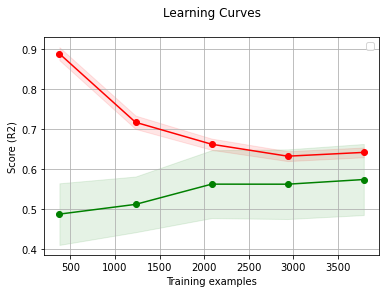

In [32]:
plot_learning_curves(model, X, y, scoring="R2", cv=10, n_jobs=4)

The learning curves look ok. There's no sign of overfitting.  
We fit the model and then we can try to do some predictions.

In [33]:
model.fit(X, y)

GradientBoostingRegressor()

In [39]:
y_pred = model.predict(test.drop("ID", axis=1))
print(y_pred)

[ 92.47350022 110.14542681  92.35442419 ...  93.92637487 112.15922668
  93.46914853]
